In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import patches, lines
import pickle
%matplotlib inline

colors = pickle.load(open('./colors.p', 'rb'))
sns.set(style='whitegrid', font_scale=1.2)

In [2]:
def plot_fitness_v_frequency(fitness, actual_frequencies, axes = None):
    if not axes:
        w = 7.5
        h = 8.75*2/3
        fig, axes = plt.subplots(2,1,figsize=(w,h), sharex=True, gridspec_kw={'wspace':0.025, 'hspace':0.1})
        show = True
    else:
        show = False
    for clade in fitness.columns.values:
        c = colors[clade]
        axes[1].plot(fitness[clade].index.values, fitness[clade], c=c, linestyle=':', label=clade)
        axes[0].plot(actual_frequencies[clade].index.values, actual_frequencies[clade], c=c, linestyle='-')

    axes[1].set_ylabel('Antigenic fitness')
    axes[0].set_ylabel('Observed frequency')
    
    axes[0].set_ylim(0,1)
    axes[0].set_xlim(actual_frequencies.index.min(), fitness.index.max())
    axes[1].set_xlim(actual_frequencies.index.min(), fitness.index.max())
    plt.sca(axes[0])
    
    if not show:
        return axes
    else:
        plt.show()

In [3]:
def plot_growth_rates(actual, predicted, ax=None, c = 'gray'):
    '''
    For the actual and predicted actual_frequencies, find where both values are non-null and > 0.1
    Plot actual vs. predicted
    '''
    if not ax:
        w = 7.5/3
        h = w
        fig, ax = plt.subplots(figsize=(w,h))
        show = True
    else:
        show = False
    
    actual = actual.loc[actual.index.isin(predicted.index.values)]

    assert predicted.columns.tolist() == actual.columns.tolist()
    assert actual.index.tolist() == predicted.index.tolist()

    actual, predicted = actual.values.flatten(), predicted.values.flatten()
    mask = (~np.isnan(actual)) & (~np.isnan(predicted))
    fit = stats.linregress(actual[mask], predicted[mask])

    sns.regplot(actual[mask], predicted[mask], ax = ax, scatter_kws={'alpha': 0.2}, color = c)
    ax.set_xlabel('Observed growth rate')
    ax.set_ylabel('Predicted growth rate')
    ax.text(1,1,r'$\rho =$%.2f'%fit[2], transform=ax.transAxes, ha='right', va='top')
    plt.tight_layout()
    
    
#     plt.plot(ax.get_xlim(), ax.get_xlim(), c='gray', linestyle='--')
    max_val = actual[mask].flatten().max()
    ax.set_xlim(0,max_val)
    ax.set_ylim(0,max_val)
    ax.set_yticks(ax.get_xticks())
    fp = patches.Rectangle((1,0), width=ax.get_xlim()[1]-1, height = 1, 
                           fc = 'gray',  alpha=0.3)
    fn = patches.Rectangle((0,1), width = 1, height = ax.get_ylim()[1]-1, 
                           fc= 'gray', alpha = 0.3)
    ax.add_patch(fp)
    ax.add_patch(fn)    
    if show:
        plt.show()
    else:
        return ax

# plot_growth_rates(actual_growth_rates, prediced_growth_rates, c = colors['interserotype_effects'])

In [4]:
def plot_trajectory_example(actual_frequencies, predicted_trajectory, ax = None):
    if not ax:
        fig, ax = plt.subplots(figsize=(7.5*2/3, 7.5/3))
        show = True
    else:
        show = False
    
    t0 = predicted_trajectory.index.min()
    t_back = t0 - 2.
    t_fwd = t0 + 5.
    
    for clade, trajectory in predicted_trajectory.iteritems():
        c = colors[clade]
        actual_vals = actual_frequencies[clade][t_back:t_fwd]
        ax.plot(actual_vals.index.values, actual_vals.values, c=c)
        ax.plot(trajectory.index.values, predicted_trajectory[clade].values, c=c, linestyle='--')
    ax.set_xlim(t_back, t_fwd)
    ax.set_ylim(0,1)
    ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    if show:
        plt.show()
    else:
        return ax

In [24]:
def add_subfigure_label(ax, label, x=-0.13, y=1.0):
    ax.text(x, y, label, va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=ax.transAxes)

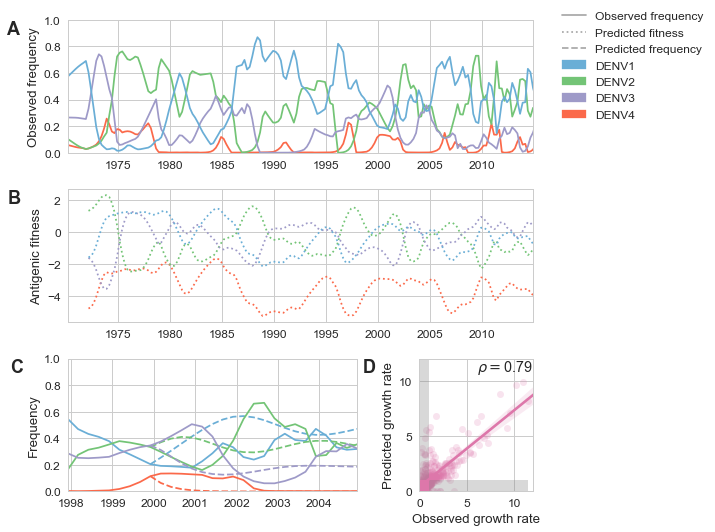

In [30]:
##### SEROTYPES: composite Figure 4

actual_frequencies = pd.read_csv('../frequencies/source/southeast_asia_serotype_frequencies.csv', index_col=0)
predicted_fitness = pd.read_csv('../frequencies/southeast_asia/serotype/seasia_dt5_sseparams_fitness.csv', index_col=0)
predicted_growth_rates = pd.read_csv('../frequencies/southeast_asia/serotype/seasia_dt5_sseparams_predicted_growth_rates.csv', index_col=0)
actual_growth_rates = pd.read_csv('../frequencies/southeast_asia/serotype/seasia_dt5_sseparams_actual_growth_rates.csv', index_col=0)
trajectory_demo = pd.read_csv('../frequencies/southeast_asia/serotype/seasia_dt5_sseparams_2000.0_trajectory.csv', index_col=0)

fig = plt.figure(figsize=(7.5, 7.5))
axes = gridspec.GridSpec(nrows = 3, ncols=3)
    
actual_freq_ax = plt.subplot(axes[0,:])
add_subfigure_label(actual_freq_ax, 'A')
fitness_ax = plt.subplot(axes[1,:])
add_subfigure_label(fitness_ax, 'B')
trajectory_ax = plt.subplot(axes[2,:-1])
add_subfigure_label(trajectory_ax, 'C', x=-0.2)
growth_ax = plt.subplot(axes[2, -1])
add_subfigure_label(growth_ax, 'D', x=-0.5)

plot_fitness_v_frequency(predicted_fitness, actual_frequencies, axes=[actual_freq_ax, fitness_ax])
plot_trajectory_example(actual_frequencies, trajectory_demo, ax=trajectory_ax)
plot_growth_rates(actual_growth_rates, predicted_growth_rates,ax=growth_ax, c=colors['interserotype_effects'])
growth_ax.set_xlim(0, 12)
growth_ax.set_ylim(0,11)

legend_handles = [ lines.Line2D([], [], color='darkgray', linestyle='-',label='Observed frequency'),
                   lines.Line2D([], [], color='darkgray', linestyle=':',label='Predicted fitness'),
                   lines.Line2D([], [], color='darkgray', linestyle='--',label='Predicted frequency')]
legend_labels = ['Observed frequency', 'Predicted fitness', 'Predicted frequency']
for cl in actual_frequencies.columns.values:
    legend_patch = patches.Patch( color=colors[cl], label=cl)
    legend_handles.append(legend_patch)
    legend_labels.append(cl)

fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.3,1),bbox_transform=plt.gcf().transFigure)
plt.show()

In [5]:
### GENOTYPES: Figure 5
actual_frequencies = pd.read_csv('../frequencies/source/southeast_asia_genotype_frequencies.csv', index_col=0)
actual_growth_rates = pd.read_csv('../frequencies/southeast_asia/genotype/all_effects/seasia_allEffects_dt5_sseparams_actual_growth_rates.csv', index_col=0)
all_effects_growth_rates = pd.read_csv('../frequencies/southeast_asia/genotype/all_effects/seasia_allEffects_dt5_sseparams_predicted_growth_rates.csv', index_col=0)
all_effects_fitness = pd.read_csv('../frequencies/southeast_asia/genotype/all_effects/seasia_allEffects_dt5_sseparams_fitness.csv', index_col=0)

interserotype_growth_rates = pd.read_csv('../frequencies/southeast_asia/genotype/interserotype_effects/seasia_interserotypeEffects_dt5_sseparams_predicted_growth_rates.csv', index_col=0)

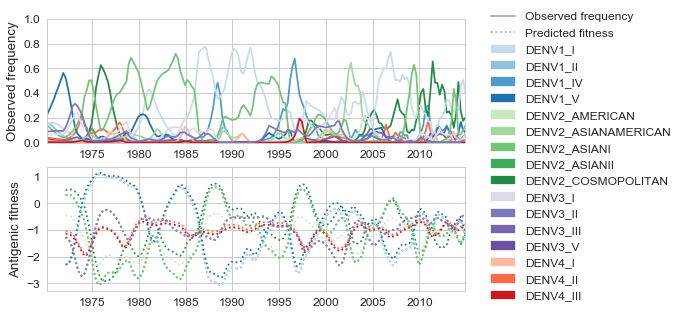

In [8]:
### GENOTYPES: Figure 5

fig = plt.figure(figsize=(7.5, 7.5*2/3))
axes = gridspec.GridSpec(nrows = 2, ncols=1)
    
actual_freq_ax = plt.subplot(axes[0,0])
fitness_ax = plt.subplot(axes[1,0])

plot_fitness_v_frequency(all_effects_fitness, actual_frequencies, axes=[actual_freq_ax, fitness_ax])

legend_handles = [ lines.Line2D([], [], color='darkgray', linestyle='-',label='Observed frequency'),
                   lines.Line2D([], [], color='darkgray', linestyle=':',label='Predicted fitness'),]
legend_labels = ['Observed frequency', 'Predicted fitness']
for cl in sorted(actual_frequencies.columns.values.tolist()):
    legend_patch = patches.Patch( color=colors[cl], label=cl)
    legend_handles.append(legend_patch)
    legend_labels.append(cl)
    
fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.3,.93),bbox_transform=plt.gcf().transFigure)
plt.savefig('./png/genotype-fitness.png', dpi=300, bbox_inches='tight')
plt.show()

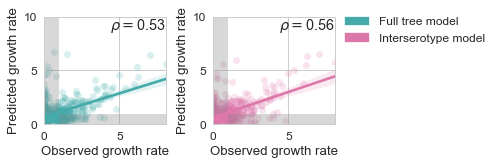

In [9]:
## GENOTYPES: FIGURE 6

fig = plt.figure(figsize=(7.5*2/3, 7.5/3))
axes = gridspec.GridSpec(nrows = 1, ncols=2)
    
all_effects_ax = plt.subplot(axes[0,0])
interserotype_effects_ax = plt.subplot(axes[0,1])

plot_growth_rates(actual_growth_rates, all_effects_growth_rates,all_effects_ax,c=colors['all_effects'])
plot_growth_rates(actual_growth_rates, interserotype_growth_rates,interserotype_effects_ax,c=colors['interserotype_effects'])

legend_handles = [patches.Patch(color=colors['all_effects']),patches.Patch(color=colors['interserotype_effects'])]
legend_labels = ['Full tree model', 'Interserotype model']

fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.4,.93),bbox_transform=plt.gcf().transFigure)
plt.savefig('./png/genotype_growth_rates.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# def dominant_strain(tp, frequencies):
#     return frequencies.loc[tp].idxmax()
    
# def find_dominant_period(start_tp, frequencies):
#     start_clade = dominant_strain(start_tp, frequencies)
#     timepoints = frequencies.index.tolist()
    
#     tp_idx = timepoints.index(start_tp)
#     clade = start_clade
    
#     while clade == start_clade and tp_idx < len(timepoints)-1:
#         clade = dominant_strain(timepoints[tp_idx], frequencies)
#         tp_idx += 1
#     else:
#         return timepoints[tp_idx]
    
# def find_avg_dominance_length(frequencies):
    
#     timepoints = frequencies.index.tolist()
#     tp_idx = 0
    
#     turnover_length = []

#     while tp_idx < len(timepoints):
#         start = timepoints[tp_idx]
#         end = find_dominant_period(start, frequencies)
#         turnover_length.append(end - start)
#         tp_idx = timepoints.index(end)+1
        
#     return float(sum(turnover_length))/float(len(turnover_length))

# serotype_turnover_len = find_avg_dominance_length(actual_frequencies)
# print serotype_turnover_len